# Planify - User constrains to floor plan

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

<a id='Imports'></a>
### Imports

In [158]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
from collections import defaultdict

import random
from torch_geometric.utils import from_networkx
import shapely
# from shapely import Point, MultiPolygon, GeometryCollection, Polygon, ops, LineString, unary_union, intersection_all
from shapely.geometry import Point, Polygon, MultiPolygon, Point, LineString, box
import shapely.affinity as aff
from shapely.wkt import loads
import geopandas as gpd
# to show advance in for loops
from tqdm import tqdm

<a id='func'></a>
### Functions used

In [159]:
room_embeddings = {
    'living': 0,
    'room': 1,
    'kitchen': 2,
    'bathroom': 3,
    'balcony': 4
}


poly_types = list(room_embeddings.keys())
N = len(poly_types)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(poly_types)}

In [160]:
def Handling_dubplicated_nodes(boundary, door):
    
    """
    This function is used to handle the duplicated nodes in the boundary graph.
    As some coords of the boundary graph are near to each other, so we will consider them the same node.
    
    Input:
        boundary graph, front door as polygons
    Output:
        boundary graph with no duplicated nodes. Also with the front door embedded.
    """
    
    coords = boundary.exterior.coords[:]
        
    # creating points:
    points = []
    for p in coords:
        points.append(Point(p))

    graph = nx.Graph()
    # type of the node: 0 for boundary, 1 for front_door
    graph.add_node(0, type=0, centroid=coords[0])

    # to save the index if there is a node will not be added
    current = 0
    name = 1

    for i in range(1, len(coords)):
        dis = points[i].distance(points[current])
        if dis >= 5:
            # type of the node, edge = 0, front_door = 1
            graph.add_node(name, type=0, centroid=coords[i])
            current = i
            name += 1

    # Checking the distance between first and last node [if the distance is small, so we will consider them the same point]
    nodes_names = list(graph.nodes)
    first_node = Point(graph.nodes[nodes_names[0]]['centroid'])
    last_node  = Point(graph.nodes[nodes_names[-1]]['centroid'])
    if first_node.distance(last_node) <= 5:
        graph.remove_node(nodes_names[-1])
        nodes_names = list(graph.nodes)
        
    points_of_current_graph = []
    for node in graph:
        points_of_current_graph.append(Point(graph.nodes[node]['centroid']))

    # Adding edges between nodes.
    for i in range(len(nodes_names)-1):
        dis = points_of_current_graph[i].distance(points_of_current_graph[i+1])
        graph.add_edge(nodes_names[i],nodes_names[i+1], distance=dis)

    # Adding an edge between the last and the first nodes.
    dis = points_of_current_graph[nodes_names[0]].distance(points_of_current_graph[nodes_names[-1]])

    graph.add_edge(nodes_names[0], nodes_names[-1], distance=dis)
    
    # adding the front door
    graph = adding_door(graph, door, points_of_current_graph)
    
    return graph

def adding_door(boundary_graph, door, points):
    """
    This function is used to add the front door to the boundary graph.
    Input:
        boundary graph: graph of the boundary of the floor plan.
        door: front door as polygon.
        points: list of the points of the boundary graph. to use it to detect best place for the door.
    """
    nearest_edge = None
    nearest_dist = float('inf')
    
    dx = door.bounds[2] - door.bounds[0]
    dy = door.bounds[3] - door.bounds[1]
    door_oriantation_horizontal = dx > dy

    for edge in boundary_graph.edges():
        p1 = points[edge[0]]
        p2 = points[edge[1]]

        line = LineString([p1, p2])

        # checking the oriantation of the lines.
        p1x, p1y = p1.x, p1.y
        p2x, p2y = p2.x, p2.y
        dx = abs(p2x - p1x)
        dy = abs(p2y - p1y)
        line_oriantation_horizontal = dx > dy
        
        # print(f'edge: {edge}, line is: {line_oriantation_horizontal}, door is: {door_oriantation_horizontal}')
        if door_oriantation_horizontal == line_oriantation_horizontal:
            # getting nearest - with same oriantation - edge
            dist = door.distance(line)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_edge = edge

    # print(f'nearest is: {nearest_edge}')
    boundary_graph.remove_edge(*nearest_edge)
    
    door_ind = len(boundary_graph)
    door_centroid = door.centroid
    boundary_graph.add_node(door_ind, type=1, centroid=(door_centroid.x, door_centroid.y))

    dist = door_centroid.distance(Point(boundary_graph.nodes[nearest_edge[0]]['centroid']))
    boundary_graph.add_edge(nearest_edge[0], door_ind, distance=dist)

    dist = door_centroid.distance(Point(boundary_graph.nodes[nearest_edge[1]]['centroid']))
    boundary_graph.add_edge(nearest_edge[1], door_ind, distance=dist)
    
    return boundary_graph

def centroids_to_graph(floor_plan, living_to_all=False, all_conected=False):
    """
    Generating a graph for a specific floor plan
    
    Input: 
        floor_plan: a dictionary [key: type of room, value: list of centroids]
        living_to_all: boolean, if True, we will connect all rooms to the living room.
        all_conected: boolean, if True, we will connect all rooms to each other.
    
    Output:
        G: a networkx graph represents the floor plan.
    """
    # Creating new graph
    G = nx.Graph()
    
    # Embeding each room in a node.
    for type_, list_of_centroids in floor_plan.items():
        for i, centroid in enumerate(list_of_centroids):

            currentNodeName = f'{type_}_{i}'
            G.add_node(currentNodeName,
                roomType_name = type_,
                roomType_embd = room_embeddings[type_],
                actualCentroid_x = centroid[0],
                actualCentroid_y = centroid[1])
            
                                        
    # if we need to connect all nodes to the living                    
    if living_to_all: 
        living_cen = Point(G.nodes['living_0']['actualCentroid_x'], G.nodes['living_0']['actualCentroid_y'])
        for node in G.nodes():
                if G.nodes[node]['roomType_name'] != 'living':
                    point = Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])
                    dis = living_cen.distance(point)
                    # adding edges between the living and all geoms
                    G.add_edge('living_0', node, distance=round(dis, 3))
                    
    # if we need to connect all nodes to each others  
    if all_conected: 
        for node in G.nodes():
            current_node_centeroid = Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])

            for other_node in G.nodes():
                if other_node != node: # for all other rooms
                    other_node_centeroid = Point(G.nodes[other_node]['actualCentroid_x'], G.nodes[other_node]['actualCentroid_y'])

                    dis = current_node_centeroid.distance(other_node_centeroid)
                    # adding edges between the the current node and the other nodes
                    G.add_edge(node, other_node, distance=round(dis, 3))

    return G

def draw_graph(G):
    """
    This function is used to draw the graph of rooms and user constrains.
    """
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_color=colormap, with_labels=True, font_size=12)

def draw_graph_boundary(G):
    """
    This function is used to draw the graph of the boundary of the floor plan.
    """
    
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)

<a id='wrangling'></a>
## Data wrangling


### User data / constrains

In [161]:
def scale_poly(poly, scale_factor):
    return aff.scale(poly, xfact=scale_factor, yfact=scale_factor, origin=(128, 128))


def scale_input(polygons, scale_factor):
    """
    This function is used to scale the input polygons.
    """
    if isinstance(polygons, (list, tuple)):
        return [scale_poly(i, scale_factor) for i in polygons]
    
    return scale_poly(polygons, scale_factor)
    
    
def scale_fp(boundary, door, bed_centroids, bath_centroids, scale_factor=1/128):
    return scale_input(boundary, scale_factor), scale_input(door, scale_factor), scale_input(bed_centroids, scale_factor), scale_input(bath_centroids, scale_factor)

In [162]:
def scale(x):
    if isinstance(x, tuple):
        x = Point(*x)
        
    return aff.scale(x, xfact=1, yfact=-1, origin=(128, 128))

In [163]:
# Data of the boundary of the floor plan
boundary_wkt = "POLYGON ((65.14758620689653 64.44137931034484, 154.12965517241383 64.44137931034484, 154.12965517241383 72.91586206896554, 230.4 72.91586206896554, 230.4 191.55862068965516, 25.599999999999994 191.55862068965516, 25.599999999999994 72.91586206896554, 65.14758620689653 72.91586206896554, 65.14758620689653 64.44137931034484))"

front_door_wkt = "POLYGON ((58.77053768582786 69.75029014750857, 33.44596231417212 69.75029014750857, 33.44596231417212 72.91586206896554, 58.77053768582786 72.91586206896554, 58.77053768582786 69.75029014750857))"

# Data of the inner rooms or bathrooms
room_centroids  = [(189, 102), (192, 161), (59, 162)]
bathroom_centroids = [(141, 88), (141, 172)]
# kitchen_centroids = [(100, 163)]

room_centroids_1 = [scale(x) for x in room_centroids]
bathroom_centroids_1 = [scale(x) for x in bathroom_centroids]
# kitchen_centroids_1 = [scale(x) for x in kitchen_centroids]

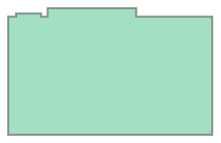

In [164]:
# Getting the boundary & front door as shapely polygons
boundary = shapely.wkt.loads(boundary_wkt)
front_door = shapely.wkt.loads(front_door_wkt)

# plotting the boundary as polygon.
import shapely.affinity as aff

boundary_1   = scale(boundary)
front_door_1 = scale(front_door)

boundary_1 | front_door_1

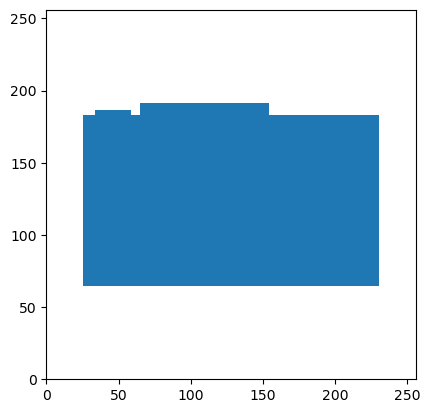

In [165]:
gpd.GeoSeries([boundary_1, front_door_1]).plot();
plt.xlim(0, 256);
plt.ylim(0, 256);

# edit

In [166]:
x1, y1, x2, y2 = boundary_1.bounds

w, h = x2 - x1, y2 - y1



In [167]:
input_largest_w = max(w, h)
poly_area = boundary_1.area
actual_area = 123.665

largest_w_real = np.sqrt(((input_largest_w ** 2) * actual_area) / poly_area)

scale = (input_largest_w * 1.2 / (largest_w_real * 18)) 
scale

0.9488717773840286

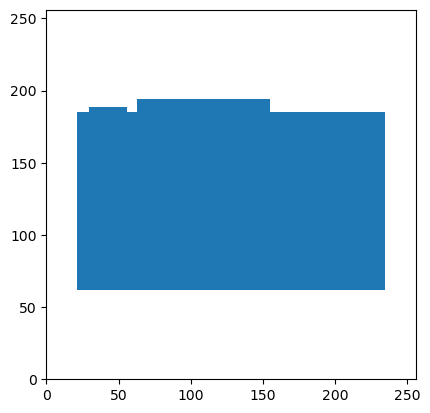

In [168]:
boundary, door, bed_centroids, bath_centroids = scale_fp(boundary_1, front_door_1, room_centroids_1, bathroom_centroids_1, factor)
gpd.GeoSeries([boundary, door]).plot();
plt.xlim(0, 256);
plt.ylim(0, 256);

In [169]:
room_centroids = [x.coords[0] for x in bed_centroids]
bathroom_centroids = [x.coords[0] for x in bath_centroids]
# kitchen_centroids = [x.coords[0] for x in kitchen_centroids]

In [170]:
boundary_graph = Handling_dubplicated_nodes(boundary, front_door)
# draw_graph_boundary(boundary_graph)

In [171]:
# Considering the center of the living room as the origin of the floor plan
living_centroid    = [(boundary.centroid.x, boundary.centroid.y)]

In [172]:
user_constraints = {
    'living': living_centroid,
    'room': room_centroids,
    'bathroom': bathroom_centroids,
    # 'kitchen': kitchen_centroids
}

G = centroids_to_graph(user_constraints, living_to_all=True)
# draw_graph(G)

<a id='archi'></a>
### Architecture

> Converting graphs to pytorch geometric graphs.

In [173]:
# Boundary graph
B_pytorch = from_networkx(boundary_graph, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])

# Floor plan graph
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
G_pytorch = from_networkx(G, group_edge_attrs=['distance'], group_node_attrs=features)

In [174]:
mean_x = G_pytorch.x[:, 1].mean().item()
mean_y = G_pytorch.x[:, 2].mean().item()

std_x = G_pytorch.x[:, 1].std().item()
std_y = G_pytorch.x[:, 2].std().item()

In [175]:
import torch
import torch.nn.functional as F
for i in [1, 2]:
    if i == 1:
        G_pytorch.x[:, i] = (G_pytorch.x[:, i] - mean_x) / std_x
    elif i == 2:
        G_pytorch.x[:, i] = (G_pytorch.x[:, i] - mean_y) / std_y
        
first_column_encodings = F.one_hot(G_pytorch.x[:, 0].long(), num_classes=7).to(torch.float)
G_pytorch.x = torch.cat([first_column_encodings, G_pytorch.x[:, 1:]], dim=1)

G_pytorch.x

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2907,
          0.1594],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.9758,
          0.9711],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0375,
         -0.7196],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.6990,
         -0.7483],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000, -0.0118,
          1.3722],
        [ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000, -0.0118,
         -1.0348]], dtype=torch.float64)

In [176]:
mean_bou_x = B_pytorch.x[:, 1].mean().item()
mean_bou_y = B_pytorch.x[:, 2].mean().item()

std_bou_x = B_pytorch.x[:, 1].std().item()
std_bou_y = B_pytorch.x[:, 2].std().item()

In [177]:
import torch
import torch.nn.functional as F
for i in [1, 2]:
    if i == 1:
        B_pytorch.x[:, i] = (B_pytorch.x[:, i] - mean_bou_x) / std_bou_x
    elif i == 2:
        B_pytorch.x[:, i] = (B_pytorch.x[:, i] - mean_bou_y) / std_bou_y
        
B_pytorch.x

tensor([[ 0.0000, -0.5553,  0.7600],
        [ 0.0000,  0.5197,  0.7600],
        [ 0.0000,  0.5197,  0.6173],
        [ 0.0000,  1.4411,  0.6173],
        [ 0.0000,  1.4411, -1.3814],
        [ 0.0000, -1.0331, -1.3814],
        [ 0.0000, -1.0331,  0.6173],
        [ 0.0000, -0.5553,  0.6173],
        [ 1.0000, -0.7450, -1.2264]], dtype=torch.float64)

In [178]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)
        
        input_of_conv2   = num_graph_node_features + 32*4
        self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)
        
        input_of_conv3   = num_graph_node_features + 32*8
        self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)
        
        input_of_conv4   = num_graph_node_features + 64*8
        self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)
        shape_of_graphs_befor_concatination = num_graph_node_features + 128*8
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
        input_of_boundary_conv2 = 32*4 + num_boundary_node_features
        self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)
        
        shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8
        
        # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)

        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)
        
        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)
        
        
        self.boundary_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch
        
        NUM_OF_NODES = x_graph.shape[0]
        # During testing, as we input only one graph.
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
        x_graph_res = x_graph
        x_boundary_res = x_boundary
        
        # Passing the graph throught a message passing to embed its features
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph) # Concatinate with step connection from real values.
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        
        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph) 
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)

        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)
        
        
        width = F.leaky_relu(self.width_layer1(x))
        width = self.dropout(width)
        width = self.width_output(width)
        
        height = F.leaky_relu(self.height_layer1(x))
        height = self.dropout(height)
        height = self.height_output(height)
        
        return width.squeeze(), height.squeeze()

num_graph_node_features = G_pytorch.x.shape[1]
num_boundary_node_features = B_pytorch.x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (boundary_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [179]:
checkpoint_path = r"Regressions\squares_w_h\checkpoints\v2\Best_model_V2.pt"
checkpoint = torch.load(checkpoint_path)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer.param_groups[0]['params'][0].data.float()
epochs = checkpoint['epoch']

model.eval()

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (boundary_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [180]:
class FloorPlan_multipolygon():
    def __init__(self, graph, prediction):
        self.graph       = graph
        self.prediction  = prediction
        
    def get_room_data(self, room_index):
        """
        Inputs: 
            room_index: index of the room in the graph
            
        Outputs: 
            centroid, w, h of that room.
        """
        # # Using networkX graphs
        # Graph_data = list(self.graph.nodes(data=True))[room_index][1]
        # w = Graph_data['rec_w']
        # h = Graph_data['rec_h']
        # centroid = (Graph_data['actualCentroid_x'], Graph_data['actualCentroid_y'])
        # category = Graph_data['roomType_embd']
        
        # Using pytorhc Garphs
        
        centroid = (self.graph.x[room_index][-2].item(), self.graph.x[room_index][-1].item())
        category = torch.argmax(G_pytorch.x[:, :7], axis=1)[room_index].item()
        w_pre, h_pre = self.get_predictions(room_index)
            

        data = {
            'centroid': centroid,
            'predic_w': w_pre,
            'predic_h': h_pre,
            'category': category
        }
        return data
    
    def create_box(self, room_data):
        """
        Inputs:
            room_data: a dictionary with centroid, w, h of that room.
            
        Outputs:
            box: a shapely box with the same centroid, w, h of that room.
        """
        
        centroid = room_data['centroid']
        half_w   = room_data['predic_w'] / 2
        half_h   = room_data['predic_h'] / 2
        
        # bottom_left  = Point(centroid[0] - half_w, centroid[1] - half_h)
        # bottom_right = Point(centroid[0] + half_w, centroid[1] - half_h)
        # top_right    = Point(centroid[0] + half_w, centroid[1] + half_h)
        # top_left     = Point(centroid[0] - half_w, centroid[1] + half_h)
        
        x1 = centroid[0] - half_w
        x2 = centroid[0] + half_w
        y1 = centroid[1] - half_h
        y2 = centroid[1] + half_h
        
        # print(bottom_left, bottom_right, top_right, top_left)
        # box = Polygon([bottom_left, bottom_right, top_right, top_left])
        box_poly = box(x1, y1, x2, y2)
        return box_poly

    def get_multipoly(self, boundary=False):
        """
        Outputs:
            multi_poly: a shapely multipolygon of all the rooms in the floor plan or graph.
        """
        num_of_rooms = self.graph.x.shape[0]
        similar_polygons = defaultdict(list)
        
        for index in range(num_of_rooms):
            room_data = self.get_room_data(index)
            box = self.create_box(room_data)
            box = box.intersection(boundary.buffer(-3, cap_style=3, join_style=2))
            # add each pox to its similar boxes
            room_category = room_data['category']
            if room_category != 0:
                similar_polygons[room_category].append(box)

        
        all_polygons = []
        all_polygons.append(boundary)
        for _, polygons in similar_polygons.items():
            all_polygons.append(MultiPolygon(polygons))
        
        # all_polygons.append(boundary)
        compined_polygons_seperated = gpd.GeoSeries(all_polygons)
        
        return compined_polygons_seperated
    
    def get_predictions(self, room_index):
        """
        Inputs: 
            room_index: index of the room in the graph
        outputs: 
            w_predicted: predicted width for that room
            h_predicted: predicted width for that room
        """
        w_predicted = self.prediction[room_index, 0]
        h_predicted = self.prediction[room_index, 1]
        
        return w_predicted, h_predicted

In [181]:
G_pytorch.x = G_pytorch.x.to(torch.float32)
G_pytorch.edge_attr = G_pytorch.edge_attr.to(torch.float32)
G_pytorch.edge_index = G_pytorch.edge_index.to(torch.int64)

B_pytorch.x = B_pytorch.x.to(G_pytorch.x.dtype)
B_pytorch.edge_index = B_pytorch.edge_index.to(G_pytorch.edge_index.dtype)
B_edge_attr = B_pytorch.edge_attr.to(G_pytorch.edge_attr.dtype)

In [182]:
prediction = model(G_pytorch.to(device), B_pytorch.to(device))

w_predicted   = prediction[0].detach().cpu().numpy()
h_predicted   = prediction[1].detach().cpu().numpy()
prediction = np.concatenate([w_predicted.reshape(-1, 1), h_predicted.reshape(-1, 1)], axis=1)

In [183]:
# Get back real values of centroids to use them In the visualization
G_pytorch.x[:, -2] = G_pytorch.x[:, -2] * std_x + mean_x
G_pytorch.x[:, -1] = G_pytorch.x[:, -1] * std_y + mean_y

B_pytorch.x[:, -2] = B_pytorch.x[:, -2] * std_bou_x + mean_bou_x
B_pytorch.x[:, -1] = B_pytorch.x[:, -1] * std_bou_y + mean_bou_y

# see

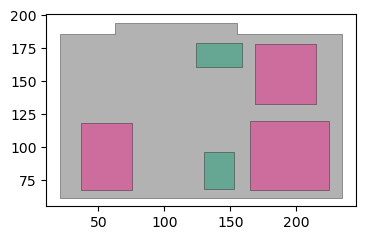

In [184]:
# w_h_predicted = model(G.to(device), B.to(device)).detach().cpu().numpy()
test = FloorPlan_multipolygon(G_pytorch, prediction=prediction)

polys = test.get_multipoly(boundary)
polys.plot(cmap='Dark2_r', figsize=(4, 4), alpha=0.5, linewidth=0.5, edgecolor='black');

In [185]:
(6 * 16) / 4

24.0